In [1]:
import matplotlib.pyplot as plt
import glob
import os
import lal
import h5py
import json
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy import integrate
from pycbc.filter import match,overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
from pycbc.waveform import utils as wfutils
from pycbc.waveform.waveform import _filter_time_lengths,props,get_fd_waveform, get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc import pnutils
from pyrex.tools import find_roots, find_intercept
from pyrex.core import *

In [2]:
import matplotlib as mpl
fig_width_pt = 450.  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt*1.2  # width in inches
fig_height = fig_width*golden_mean*1.4      # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'pdf',
             'axes.labelsize': 25,
             'font.size': 18,
             'legend.fontsize': 18,
             'xtick.labelsize': 18,
             'ytick.labelsize': 18,
             'text.usetex': True,
             'figure.figsize': fig_size,
             'font.family': 'serif'}
mpl.rcParams.update(params)

In [3]:
data_path = "/Users/yesety/Documents/AEI/projects/eccentric/catalog_ecc/"

name=[]
name.append(['SXS_BBH_0180','SXS_BBH_1355','SXS_BBH_1357','SXS_BBH_1358','SXS_BBH_1359','SXS_BBH_1360','SXS_BBH_1361','SXS_BBH_1362','SXS_BBH_1363'])
name.append(['SXS_BBH_0184','SXS_BBH_1364','SXS_BBH_1365','SXS_BBH_1366','SXS_BBH_1367','SXS_BBH_1368','SXS_BBH_1369'])
name.append(['SXS_BBH_0183','SXS_BBH_1372','SXS_BBH_1373','SXS_BBH_1374'])

e_comm=[]
e_comm.append([0,0.053,0.097,0.099,0.100,0.142,0.144,0.189,0.192])
e_comm.append([0,0.044,0.06,0.095,0.096,0.097,0.185])
e_comm.append([0,0.092,0.093,0.18]) #Hinder Phys Rev D 98 2018

l_comm=[]
l_comm.append([0.667,-2.788,1.371,-1.742,2.743,2.178,1.550,1.042,0.732])
l_comm.append([-0.604,2.144,1.938,1.013,-0.709,-1.963,-1.465])
l_comm.append([1.818,2.998,1.677,-0.265]) #Hinder Phys Rev D 98 201

q=[]
q.append(list(np.ones(len(e_comm[0]))+0))
q.append(list(np.ones(len(e_comm[1]))+1))
q.append(list(np.ones(len(e_comm[2]))+2))

data={}
data['name']=name[0]+name[1]+name[2]
data['e_comm']=e_comm[0]+e_comm[1]+e_comm[2]
data['q']=q[0]+q[1]+q[2]
data['l_comm']=l_comm[0]+l_comm[1]+l_comm[2]

In [4]:
all_data=Glassware(q=data['q'],chi=0,data_path=data_path,names=data['name'],e_ref=data['e_comm'])
all_data.components()
all_data.compute_e_estimator()

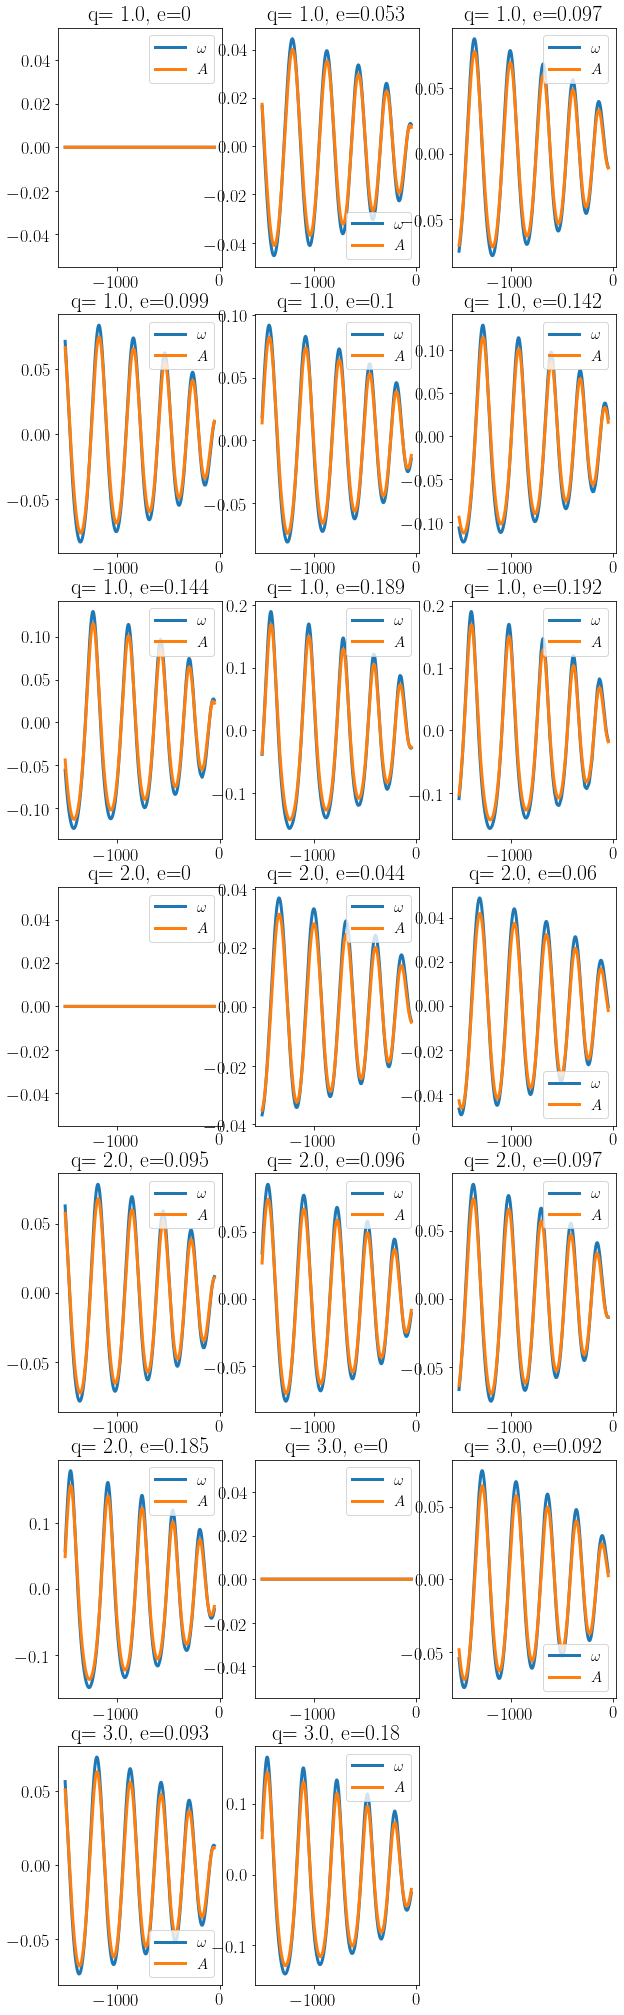

In [5]:
fig = plt.figure(figsize=(10,36))
for i in range(len(data['name'])):
    plt.subplot(7,3,i+1)
    plt.plot(all_data.new_time,all_data.eX_omega[i],lw=3,label='$\omega$')
    plt.plot(all_data.new_time,all_data.eX_amp[i],lw=3,label='$A$')
    plt.legend(fontsize='small')
    plt.title('q= '+str(all_data.q[i])+', e='+str(all_data.e_ref[i]))

In [6]:
all_data.fit_model()

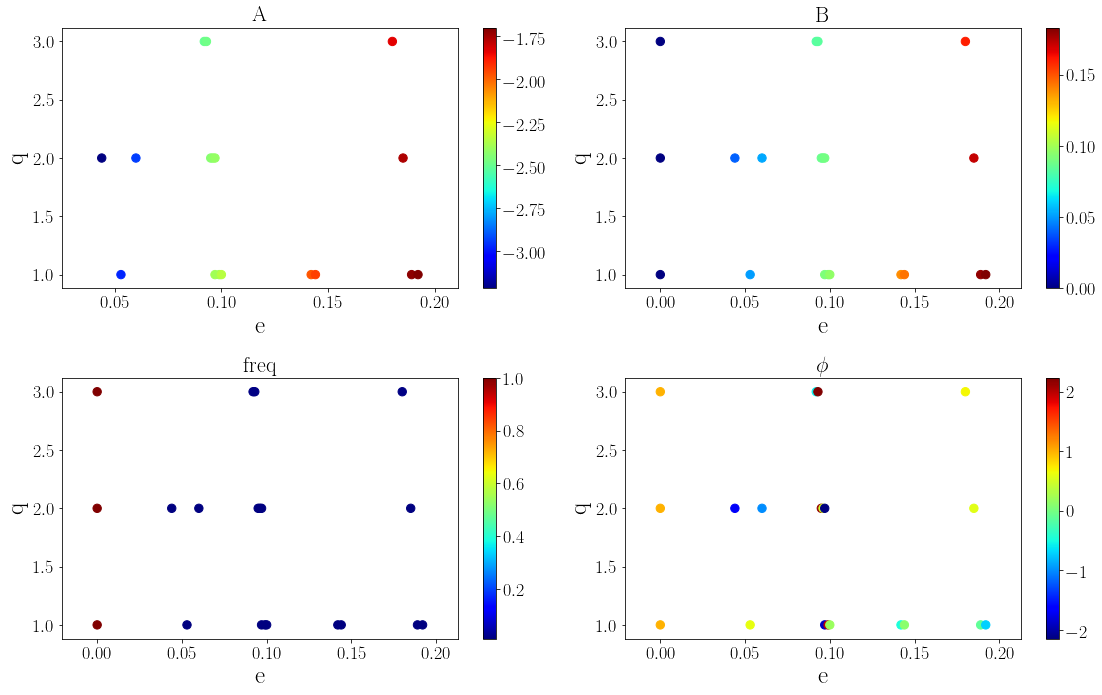

In [15]:
plt.figure(figsize=(16,10))
cm=plt.cm.get_cmap('jet')
plt.subplot(221)
sc1=plt.scatter(all_data.e_ref,all_data.q,c=np.log(all_data.A_omega),cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('A')
plt.colorbar(sc1)
plt.subplot(222)
sc2=plt.scatter(all_data.e_ref,all_data.q,c=all_data.A_omega*np.exp(all_data.B_omega),cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('B')
plt.colorbar(sc2)
plt.subplot(223)
sc3=plt.scatter(all_data.e_ref,all_data.q,c=all_data.freq_omega**2,cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('freq')
plt.colorbar(sc3)
plt.subplot(224)
sc4=plt.scatter(all_data.e_ref,all_data.q,c=all_data.phi_omega,cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('$\phi$')
plt.colorbar(sc4)
plt.tight_layout()

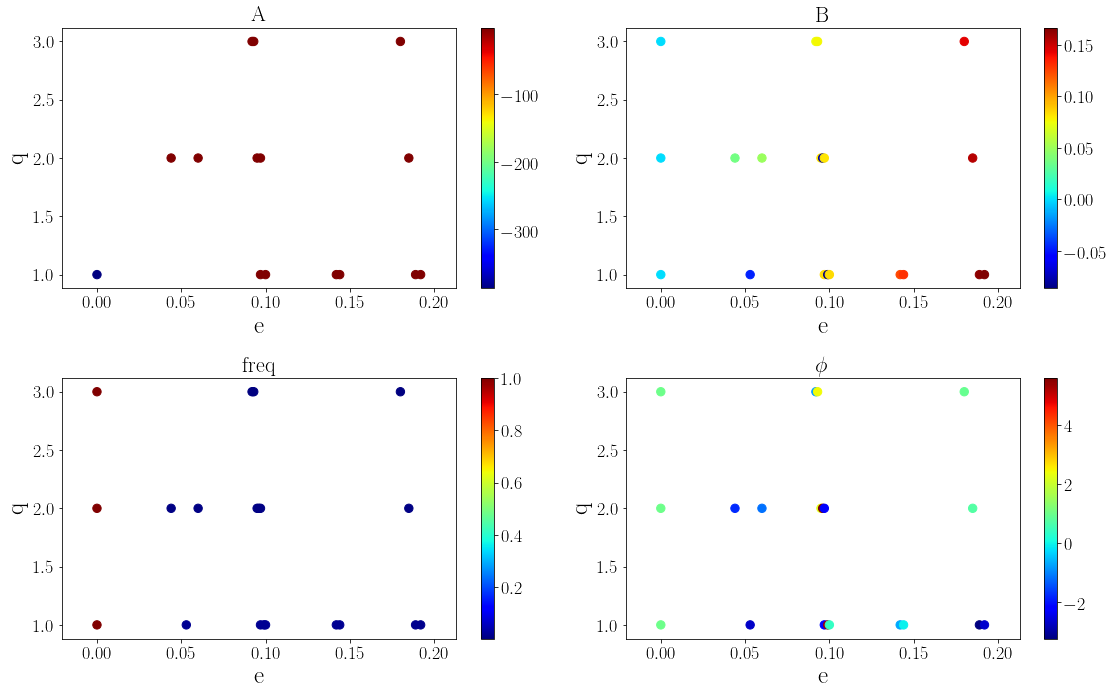

In [17]:
plt.figure(figsize=(16,10))
cm=plt.cm.get_cmap('jet')
plt.subplot(221)
sc1=plt.scatter(all_data.e_ref,all_data.q,c=np.log(all_data.A_amp),cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('A')
plt.colorbar(sc1)
plt.subplot(222)
sc2=plt.scatter(all_data.e_ref,all_data.q,c=all_data.A_amp*np.exp(all_data.B_amp),cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('B')
plt.colorbar(sc2)
plt.subplot(223)
sc3=plt.scatter(all_data.e_ref,all_data.q,c=all_data.freq_amp**2,cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('freq')
plt.colorbar(sc3)
plt.subplot(224)
sc4=plt.scatter(all_data.e_ref,all_data.q,c=all_data.phi_amp,cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('$\phi$')
plt.colorbar(sc4)
plt.tight_layout()

In [16]:
all_data.freq_omega

array([ 0.99999924,  0.10683231,  0.10679544, -0.10600286, -0.10650194,
        0.10573957,  0.10493278, -0.10336903, -0.10361335,  1.00000218,
        0.1184124 ,  0.11854805, -0.11689195, -0.11768384,  0.11774015,
       -0.11416517,  0.99999845,  0.13555259, -0.13484159, -0.1319446 ])

In [12]:
#fig = plt.figure(figsize=(19,16))
#for i in range(len(data['name'])):
#    plt.subplot(5,4,i+1)
#    if (i<9):
#        interp_omeg_c=spline(all_data.time[0],all_data.omega[0])
#        plt.plot(interp_omeg_c(all_data.new_time),all_data.eX_omega[i],label='$\omega$')
#        plt.plot(interp_omeg_c(all_data.new_time),all_data.fit_omega[i],label='fit $\omega$')
#    elif (i>8 and i<16): 
#        interp_omeg_c=spline(all_data.time[9],all_data.omega[9])
#        plt.plot(interp_omeg_c(all_data.new_time),all_data.eX_omega[i],label='$\omega$')
#        plt.plot(interp_omeg_c(all_data.new_time),all_data.fit_omega[i],label='fit $\omega$')
#    else:
#        interp_omeg_c=spline(all_data.time[16],all_data.omega[16])
#        plt.plot(interp_omeg_c(all_data.new_time),all_data.eX_omega[i],label='$\omega$')
#        plt.plot(interp_omeg_c(all_data.new_time),all_data.fit_omega[i],label='fit $\omega$')
#    plt.legend(fontsize='x-small')
#    plt.title('q= '+str(all_data.q[i])+', e='+str(all_data.e_ref[i]),fontsize='small')